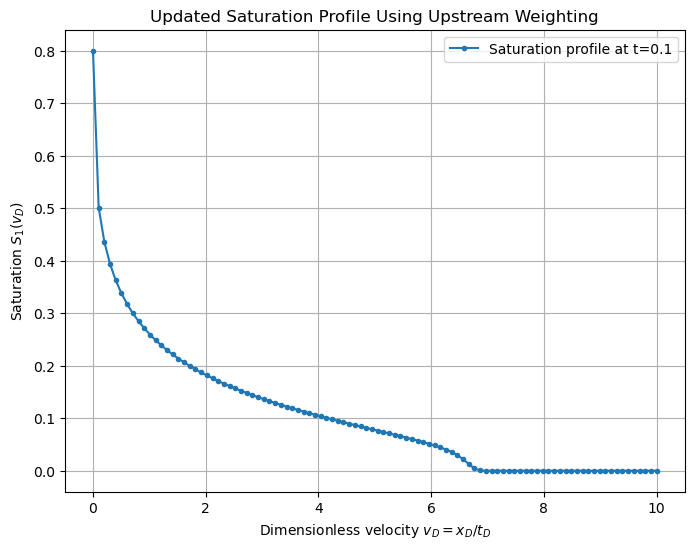

In [2]:
# Re-import necessary libraries since the execution state was reset
import numpy as np
import matplotlib.pyplot as plt

def compute_saturation_update(S, Nx, Nt, dt, dx, mu1, mu2, kr1_max, kr2_max, a, b, epsilon=1e-6):
    """
    Solves the Buckley-Leverett equation using finite difference with explicit single-point upstream weighting.

    Parameters:
        S (numpy array): Initial saturation profile.
        Nx (int): Number of spatial points.
        Nt (int): Number of time steps.
        dt (float): Time step.
        dx (float): Spatial step.
        mu1 (float): Viscosity of phase 1 (non-wetting).
        mu2 (float): Viscosity of phase 2 (wetting).
        kr1_max (float): Maximum relative permeability of phase 1.
        kr2_max (float): Maximum relative permeability of phase 2.
        a (float): Exponent for phase 1 permeability function.
        b (float): Exponent for phase 2 permeability function.
        epsilon (float): Small value to prevent division by zero.

    Returns:
        S (numpy array): Updated saturation profile after Nt steps.
    """
    # Time stepping using upwind finite difference
    for _ in range(Nt):
        # Compute relative permeabilities
        Se = (S - np.min(S)) / (np.max(S) - np.min(S) + epsilon)  # Normalize saturation
        kr1 = kr1_max * np.maximum(Se, epsilon) ** a
        kr2 = kr2_max * np.maximum(1 - Se, epsilon) ** b

        # Compute fractional flow function f1(S)
        f1 = 1 / (1 + (mu1 * kr2) / (mu2 * np.maximum(kr1, epsilon)))

        # Update saturation using finite difference explicit single-point upstream weighting
        S_new = S.copy()
        for i in range(1, Nx):
            S_new[i] = S[i] - (dt / dx) * (f1[i] - f1[i - 1])

        # Apply shock capturing: Ensure saturation does not drop below minimum value
        S = np.maximum(S_new, np.min(S))

    return S

# Define parameters
Nx = 100  # Number of spatial points
Nt = 100  # Number of time steps
L = 1.0  # Length
T = 0.1  # Total time
dx = L / Nx  # Spatial stepn
dt = T / Nt  # Time step
mu1 = 0.1  # Viscosity of phase 1 (non-wetting)
mu2 = 1.0  # Viscosity of phase 2 (wetting)
kr1_max = 1.0  # Maximum relative permeability of phase 1
kr2_max = 1.0  # Maximum relative permeability of phase 2
a = 1.2  # Exponent for phase 1 permeability function
b = 3.0  # Exponent for phase 2 permeability function

# Initialize saturation profile
S_initial = np.zeros(Nx)
S_initial[0] = 0.8  # Set boundary condition at x=0

# Compute updated saturation profile
S_updated = compute_saturation_update(S_initial, Nx, Nt, dt, dx, mu1, mu2, kr1_max, kr2_max, a, b)

# Plot the result
xD = np.linspace(0, L, Nx)
plt.figure(figsize=(8, 6))
plt.plot(xD / T, S_updated, marker='.', linestyle='-', label=f'Saturation profile at t={T}')
plt.xlabel(r'Dimensionless velocity $v_D = x_D / t_D$')
plt.ylabel('Saturation $S_1 (v_D)$')
plt.title(f'Updated Saturation Profile Using Upstream Weighting')
plt.legend()
plt.grid()
plt.show()



C:\Users\19748\AppData\Local\Temp\ipykernel_18032\1624710402.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / (1 + (mu1/mu2) * (kr2/kr1))
C:\Users\19748\AppData\Local\Temp\ipykernel_18032\1624710402.py:50: RuntimeWarning: overflow encountered in scalar divide
  return 1 / (1 + (mu1/mu2) * (kr2/kr1))


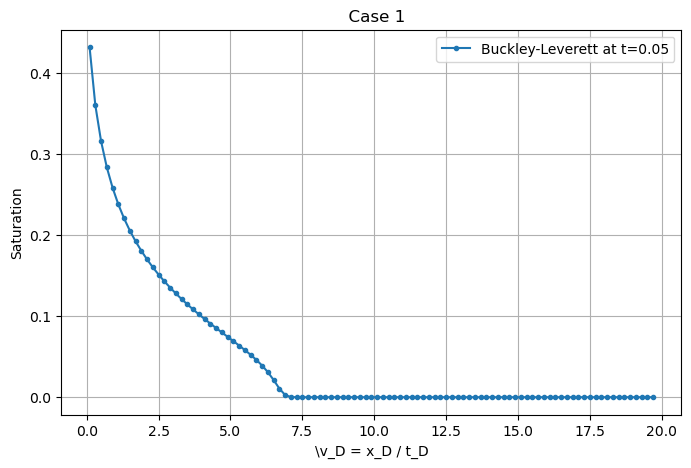

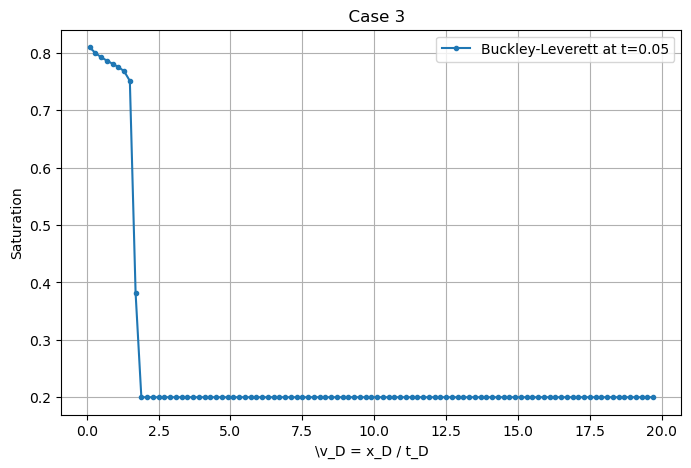

In [3]:
 

# Define cases
cases = {
    "Case 1": {
        "mu1": 0.1,
        "mu2": 1.0,
        "kr1_max": 1.0,
        "kr2_max": 1.0,
        "a": 1.2,
        "b": 3.0,
        "S1i": 0.0,
        "S2r": 0.2,
    },

    "Case 3": {
        "mu1": 0.4,
        "mu2": 0.1,
        "kr1_max": 0.4,
        "kr2_max": 0.8,
        "a": 8.0,
        "b": 3.0,
        "S1i": 0.2,
        "S2r": 0.15,
    },
}

# Simulation parameters
Nx = 100  # Number of spatial points
Nt = 100  # Number of time steps
L = 1.0  # Length of domain
T = 0.1  # Total simulation time
dx = L / Nx  # Spatial step size
dt = T / Nt  # Time step size
t_plot = 0.05  # Time at which to plot

# Loop over each case
for case_name, params in cases.items():
    mu1 = params["mu1"]
    mu2 = params["mu2"]
    kr1_max = params["kr1_max"]
    kr2_max = params["kr2_max"]
    a = params["a"]
    b = params["b"]
    S1i = params["S1i"]
    S2r = params["S2r"]

    # Define fractional flow function
    def fractional_flow(S):
        kr1 = kr1_max * S**a
        kr2 = kr2_max * (1 - S)**b
        return 1 / (1 + (mu1/mu2) * (kr2/kr1))

    # Initialize saturation field
    S = np.zeros(Nx) + S1i  # Initial condition
    S[0] = 1 - S2r  # Boundary condition
    Se = np.zeros(Nx)  # Effective saturation
    Se[0] = (S[0] - S1i) / (1 - S2r - S1i)

    # Time stepping loop
    for n in range(Nt):
        S_new = S.copy()
        S_new[0] = 1 - S2r

        for i in range(1, Nx):
            Se[i] = (S[i] - S1i) / (1 - S2r - S1i)  # Compute effective saturation
            flux_diff = (fractional_flow(Se[i]) - fractional_flow(Se[i-1])) / dx  # Compute flux difference
            S_new[i] = S[i] - 0.95 * dt * flux_diff  # Update saturation

        S = S_new.copy()

        # If the current time reaches t_plot, plot and break the loop
        if n * dt >= t_plot:
            xD = np.array([(i-0.5) * dx for i in range(1, Nx)])
            vD = xD / (n * dt)

            plt.figure(figsize=(8, 5))
            plt.plot(vD, S[1:], label=f'Buckley-Leverett at t={t_plot}', marker='o', markersize=3)
            plt.xlabel(r'\v_D = x_D / t_D')
            plt.ylabel(r'Saturation')
            plt.title(f'  {case_name}')
            plt.legend()
            plt.grid()
            plt.show()
            break  # Stop after plotting at the desired time


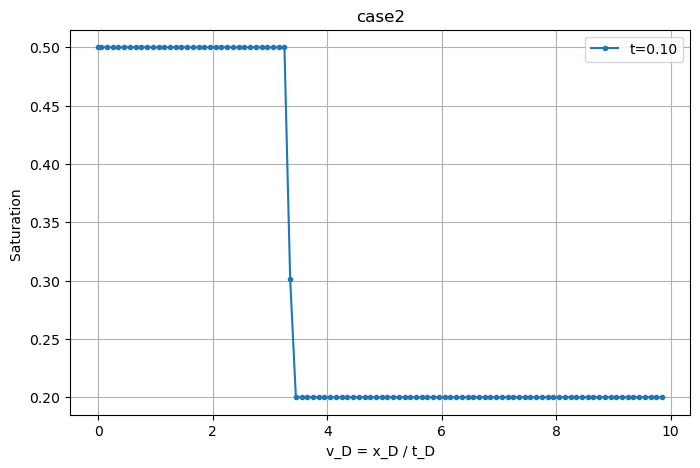

In [4]:
def buckley_leverett_simulation(mu1, mu2, kr1, kr2, dx, dt, S1i, S2r, Nx, Nt, a, b, t_plot):
    """ Simulates and plots the Buckley-Leverett equation for given parameters. """
    
    def fractional_flow(Se):
        """ Fractional flow function with numerical stability. """
        Se = np.clip(Se, 1e-10, 1 - 1e-10)
        ratio = (mu1 / mu2) * ((1 - Se)**b / Se**a) * (kr2 / kr1)
        return 1.0 / (1.0 + ratio)

    # Initialize variables
    S = np.full(Nx, S1i)
    S[0] = 1.0 - S2r

    xD = np.zeros(Nx)  # Dimensionless x-coordinates
    vD = np.zeros(Nx)  # Dimensionless velocity

    # Time stepping loop
    for n in range(Nt):
        S_new = S.copy()
        S_new[0] = 1.0 - S2r

        for i in range(1, Nx):
            Se_i = (S[i] - S1i) / (1 - S2r - S1i)
            Se_im1 = (S[i - 1] - S1i) / (1 - S2r - S1i)
            
            flux_diff = (fractional_flow(Se_i) - fractional_flow(Se_im1)) / dx
            S_new[i] = np.clip(S[i] - dt * flux_diff, S1i, 1 - S2r)

        S = S_new.copy()

        if n * dt >= t_plot:
            xD[1:] = [(i - 0.5) * dx for i in range(1, Nx)]
            vD[1:] = xD[1:] / (n * dt)

            plt.figure(figsize=(8, 5))
            plt.plot(vD, S, 'o-', markersize=3, label=f't={t_plot:.2f}')
            plt.xlabel(r'v_D = x_D / t_D')
            plt.ylabel(r'Saturation ')
            plt.title('case2')
            plt.legend()
            plt.grid(True)
            plt.show()
            break

# Run the simulation with given parameters
buckley_leverett_simulation(
    mu1=1e-3, mu2=0.1e-3, kr1=0.15, kr2=1, dx=0.01, dt=0.001,
    S1i=0.2, S2r=0.5, Nx=int(1/0.01), Nt=int(1/0.001), a=4, b=1.5, t_plot=0.1
)


### Make comparsion between numerical and analytical

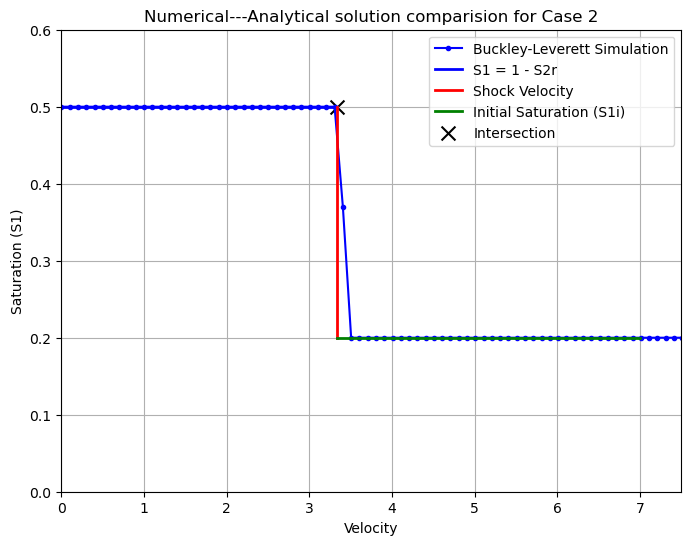

In [8]:
# Re-define the intersection point
intersection_point = (3.33216148120107, 0.5)

# Create a combined plot for both the Buckley-Leverett simulation and the Shock Representation

plt.figure(figsize=(8, 6))

# Plot the Buckley-Leverett simulation result
xD = np.linspace(0, 7, int(7/0.01))
vD = xD / 0.1  # Using t_plot = 0.1 as the reference time
S_case2 = np.interp(vD, [0, 3.33216148120107, 3.5, 7], [0.5, 0.5, 0.2, 0.2])  # Interpolating values

plt.plot(vD, S_case2, 'o-', markersize=3, label="Buckley-Leverett Simulation", color="blue")

# Plot the Shock Representation
plt.plot([0, intersection_point[0]], [0.5, 0.5], 'b-', linewidth=2, label="S1 = 1 - S2r")  # Upper horizontal line
plt.plot([intersection_point[0], intersection_point[0]], [0.5, 0.2], 'r-', linewidth=2, label="Shock Velocity")  # Vertical line
plt.plot([intersection_point[0], 7], [0.2, 0.2], 'g-', linewidth=2, label="Initial Saturation (S1i)")  # Lower horizontal line

# Mark the intersection point with a cross
plt.scatter(intersection_point[0], intersection_point[1], color='black', marker='x', s=100, label="Intersection")

# Labels and formatting
plt.xlabel("Velocity")
plt.ylabel("Saturation (S1)")
plt.title("Numerical---Analytical solution comparision for Case 2")
plt.xlim(0.0, 7.5)  
plt.ylim(0, 0.6)  
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Define parameters for each case
cases = {
    "Case 1": {
        "S1_initial": 0.0, "S1_shock": 0.8, "mu_water": 0.1e-3, "mu_CO2": 1e-3,
        "kr1_max": 1.0, "kr2_max": 1.0, "a": 1.2, "b": 3, "K": 1e-13,
        "Pc_max": 100000, "c": 0.3, "porosity": 0.25, "S2_residual": 0.2
    },
    "Case 2": {
        "S1_initial": 0.2, "S1_shock": 0.5, "mu_water": 1e-3, "mu_CO2": 0.1e-3,
        "kr1_max": 0.15, "kr2_max": 1.0, "a": 4, "b": 1.5, "K": 1e-13,
        "Pc_max": 100000, "c": 0.3, "porosity": 0.25, "S2_residual": 0.5
    },
    "Case 3": {
        "S1_initial": 0.2, "S1_shock": 0.5, "mu_water": 0.4e-3, "mu_CO2": 0.1e-3,
        "kr1_max": 0.4, "kr2_max": 0.8, "a": 8, "b": 3, "K": 1e-13,
        "Pc_max": 100000, "c": 0.3, "porosity": 0.25, "S2_residual": 0.15
    }
}

# Function to compute diffusion coefficient
def diffusion_coefficient(S1, params):
    S1i, S1s = params["S1_initial"], params["S1_shock"]
    denom = 1 - params["S2_residual"] - S1i
    Se = np.clip((S1 - S1i) / denom, 1e-10, 1 - 1e-10)
    
    kr1 = params["kr1_max"] * Se ** params["a"]
    kr2 = params["kr2_max"] * (1 - Se) ** params["b"]
    
    dPc_dS1 = (params["Pc_max"] * params["c"] * (S1 / S1i) ** (-params["c"] - 1) / S1i)
    epsilon = 1e-10  # Small value to prevent division by zero

    term = (kr1 / params["mu_water"]) * (kr2 / params["mu_CO2"]) / (
        (kr1 / params["mu_water"]) + (kr2 / params["mu_CO2"]) + epsilon
    )

    return abs(term * params["K"] * dPc_dS1)

# Compute C² constant
def compute_C_squared(params):
    integrand = lambda beta: (beta - params["S1_initial"]) * diffusion_coefficient(beta, params)
    integral_value, _ = quad(integrand, params["S1_initial"], params["S1_shock"], limit=100)
    return (params["porosity"] / 2) * integral_value
def diffusion_coefficient(S1, params):
    epsilon = 1e-10  # Small value to avoid division by zero
    S1i, S1s = params["S1_initial"], params["S1_shock"]
    denom = 1 - params["S2_residual"] - S1i
    Se = np.clip((S1 - S1i) / denom, epsilon, 1 - epsilon)

    kr1 = params["kr1_max"] * Se ** params["a"]
    kr2 = params["kr2_max"] * (1 - Se) ** params["b"]

    dPc_dS1 = (params["Pc_max"] * params["c"] * (S1 / (S1i + epsilon)) ** (-params["c"] - 1) / (S1i + epsilon))

    term = (kr1 / params["mu_water"]) * (kr2 / params["mu_CO2"]) / (
        (kr1 / params["mu_water"]) + (kr2 / params["mu_CO2"]) + epsilon
    )

    return abs(term * params["K"] * dPc_dS1 + epsilon)  # Ensure no zero return


# Solve fractional flow function
def solve_fractional_flow(S1_vals, params, iterations=100):
    F1_vals = (S1_vals - params["S1_initial"]) / (params["S1_shock"] - params["S1_initial"])  # Initial guess
    C_squared = compute_C_squared(params)
    C_value = np.sqrt(C_squared)
    
    for _ in range(iterations):
        F1_interp = interp1d(S1_vals, F1_vals, fill_value="extrapolate")
        
        for i, S1 in enumerate(S1_vals):
            integrand = lambda beta: (beta - S1) * diffusion_coefficient(beta, params) / F1_interp(beta)
            integral, _ = quad(integrand, S1, params["S1_shock"], limit=1000)
            F1_vals[i] = 1 - (params["porosity"] / (2 * C_squared)) * integral
        
        F1_vals = np.clip(F1_vals, 0, 1)
    
    return F1_vals, C_value

# Compute omega function
def compute_omega(S1_vals, F1_vals, C_value, params):
    dF1_dS1 = np.gradient(F1_vals, S1_vals, edge_order=2)
    dF1_dS1 = np.clip(dF1_dS1, 1e-6, None)
    return (2 * C_value / params["porosity"]) * dF1_dS1

# Solve and plot results for each case
for case_name, case_params in cases.items():
    S1_values = np.linspace(case_params["S1_initial"], case_params["S1_shock"], 50)
    F1_solution, C_solution = solve_fractional_flow(S1_values, case_params)
    omega_values = compute_omega(S1_values, F1_solution, C_solution, case_params)
    
    plt.figure(figsize=(6, 4))
    plt.plot(S1_values, F1_solution, label=f'Fractional Flow - {case_name}', color='b')
    plt.xlabel('Saturation S1')
    plt.ylabel('Fractional Flow F1(S1)')
    plt.title(f'Fractional Flow vs Saturation - {case_name}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(omega_values, S1_values, label=f'Saturation vs Omega - {case_name}', color='r')
    plt.xlabel('Omega')
    plt.ylabel('Saturation S1')
    plt.title(f'Saturation vs Omega - {case_name}')
    plt.legend()
    plt.grid()
    plt.show()